In [1]:
from datasets import load_dataset,DatasetDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import os
from PIL import Image
import random
import torchvision.transforms as transforms
import utils
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import time

/home/omar/TUM/05_projects/Image_generation_with_VAE/vae_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("Karthik11232/human_face_generation")
#split the dataset 
train_test_set = ds['train'].train_test_split(test_size=0.2)
#print(train_test_set)
train_val_set = train_test_set['train'].train_test_split(test_size=0.2)

ds = DatasetDict({
    'train': train_test_set['train'],
    'test': train_test_set['test'],
    'validation': train_val_set['test']
})
#print (ds)
print(ds.shape)
print(train_test_set.shape)
print(train_val_set.shape)

{'train': (2132, 1), 'test': (533, 1), 'validation': (427, 1)}
{'train': (2132, 1), 'test': (533, 1)}
{'train': (1705, 1), 'test': (427, 1)}


In [3]:
# Save the datasets to disk
output_dir = './human_face_generation_split/raw'
if not os.path.exists(output_dir):  
    os.makedirs(output_dir, exist_ok=True)
# Save each split to disk
    utils.save_images(ds['train'], 'train',output_dir)
    utils.save_images(ds['validation'], 'validation')
    utils.save_images(ds['test'], 'test')

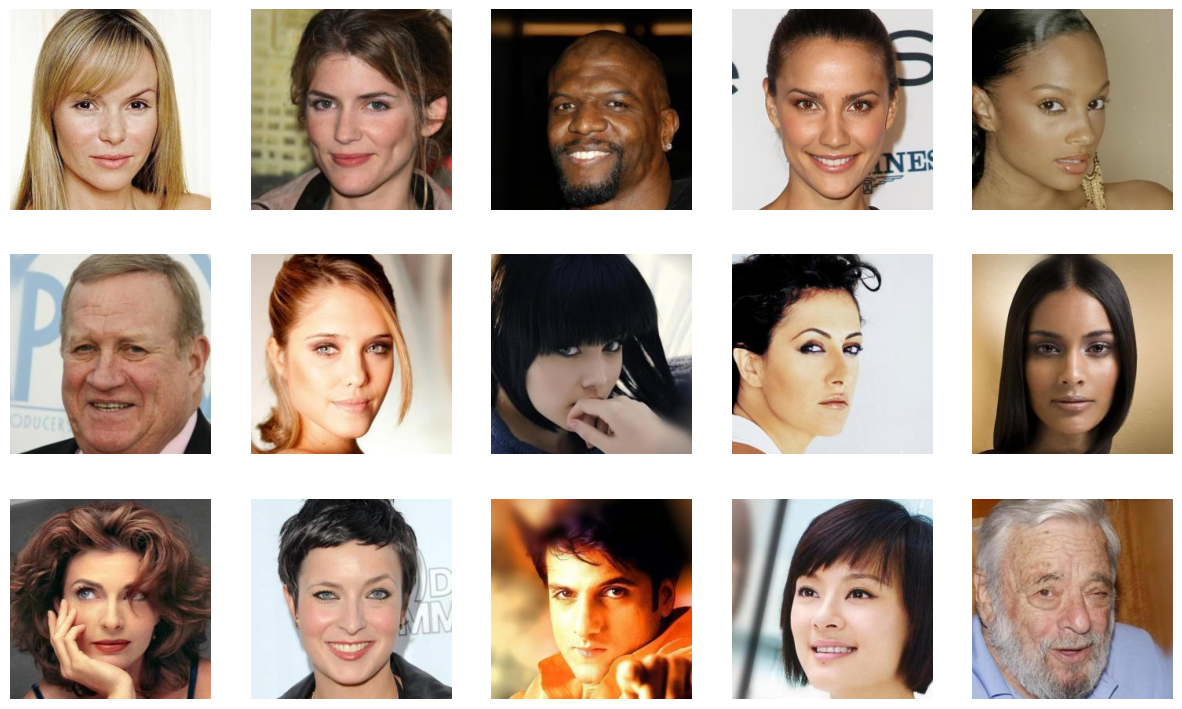

In [4]:
# Plot 15 random images in 3 rows and 5 columns
utils.plot_random_images(dataset_path='human_face_generation_split/raw/train', num_images=15, rows=3, cols=5)

In [5]:
# Prepoccessing 
preprocess = transforms.Compose([
    transforms.Resize((200, 200)),  # Resize to a specific size if needed
    transforms.ToTensor(),          # Convert to tensor and normalize
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
preprocessed_output_dir = './human_face_generation_split/preprocessed'
os.makedirs(preprocessed_output_dir, exist_ok=True)
if not os.path.exists(preprocessed_output_dir):
# Save preprocessed training images

    utils.save_images(ds['train'], 'train', preprocessed_output_dir,preprocess=preprocess)
    utils.plot_random_images(os.path.join(preprocessed_output_dir, 'train'), num_images=15, rows=3, cols=5)
    img = Image.open("human_face_generation_split/preprocessed/train/image_2110.png")
    print(img.size)


In [6]:
# first implement a simple Autoencoder with Linear layers
class Autoencoder_linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.size_hidden_layers = 512 
        self.encoder = nn.Sequential(
            nn.Linear(40000,1000),
            nn.ReLU(),
            nn.Linear(1000,self.size_hidden_layers),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.size_hidden_layers,1000),
            nn.ReLU(),
            nn.Linear(1000,40000),
            nn.ReLU(),
        )
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
   # init_weights(self.encoder)
    def forward(self,x):
        encoded=self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

In [7]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self,image_folder):
        self.image_folder=image_folder
        self.images = os.listdir (image_folder)
        self.transform = transforms.Compose([
            transforms.Resize((200, 200)),  # Resize images to 200x200
            transforms.ToTensor()           # Convert images to PyTorch tensors
        ])
    def __getitem__(self,idx):
        image_file = self.images[idx]
        image = Image.open((self.image_folder +"/"+ image_file))
        image = self.transform(image)
        image = np.array(image).reshape(-1,200*200)


        image = torch.Tensor(image)
       # print (image.shape)
        return image
    def __len__(self):
        return len(self.images)
    
dataset_preprocessed = ImageDataset("human_face_generation_split/preprocessed/train")
dataset_val = ImageDataset("human_face_generation_split/raw/validation")
dataset_test = ImageDataset("human_face_generation_split/raw/test")
show_dataset = ImageDataset("human_face_generation_split/show_imgs/train")

train_data = torch.utils.data.DataLoader(dataset_preprocessed,batch_size=64,shuffle=True)
val_data = torch.utils.data.DataLoader(dataset_val)
test_data = torch.utils.data.DataLoader(dataset_test)
show_data =torch.utils.data.DataLoader(show_dataset)

In [8]:
#ckp_path="human_face_generation_split_data{}.ckp"
crt_time = time.strftime("%Y%m%d_%H%M%S")
dir_ckpt = os.path.join("human_face_generation_split/",str(crt_time))
os.mkdir(dir_ckpt)
writer = SummaryWriter()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
linear_auto = Autoencoder_linear()
print(linear_auto)
linear_auto.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(linear_auto.parameters(), lr=1e-4)
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

epochs =  100
#training
# Training
for epoch in range(epochs):
    total_loss = 0
    with tqdm(train_data, unit="batch", total=len(train_data), desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
        for batch_idx, data in enumerate(tepoch):
            data = data.to(device)
            encoded, decoded = linear_auto(data)
            loss = loss_function(decoded, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            
            # Set the postfix with current loss
            tepoch.set_postfix(loss=total_loss / ((batch_idx + 1) * data.size(0)))
            writer.add_scalar("Loss/train", loss, epoch)

            #print(decoded.shape)

    if epoch % 2 == 0:
        linear_auto.eval()  # Set the model to evaluation mode
        ckpt_file = os.path.join(dir_ckpt, f"checkpoint_epoch_{epoch+1}.pt")

        torch.save({
            'epoch': epoch,
            'state_dict': linear_auto.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss,
            
        },ckpt_file)
    epoch_loss = total_loss / len(train_data.dataset)
    print(f"Epoch {epoch+1}/{epochs} : loss = {epoch_loss:.4f}")

cuda:0
Autoencoder_linear(
  (encoder): Sequential(
    (0): Linear(in_features=40000, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=512, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=40000, bias=True)
    (3): ReLU()
  )
)


Epoch 1/100: 100%|██████████| 34/34 [01:32<00:00,  2.71s/batch, loss=0.479]


Epoch 1/100 : loss = 0.1527


Epoch 2/100: 100%|██████████| 34/34 [01:33<00:00,  2.74s/batch, loss=0.382]


Epoch 2/100 : loss = 0.1218


Epoch 3/100: 100%|██████████| 34/34 [01:32<00:00,  2.71s/batch, loss=0.361]


Epoch 3/100 : loss = 0.1150


Epoch 4/100: 100%|██████████| 34/34 [01:28<00:00,  2.61s/batch, loss=0.323]


Epoch 4/100 : loss = 0.1031


Epoch 5/100: 100%|██████████| 34/34 [01:23<00:00,  2.46s/batch, loss=0.287] 


Epoch 5/100 : loss = 0.0915


Epoch 6/100: 100%|██████████| 34/34 [00:47<00:00,  1.41s/batch, loss=0.251] 


Epoch 6/100 : loss = 0.0801


Epoch 7/100: 100%|██████████| 34/34 [00:19<00:00,  1.75batch/s, loss=0.228] 


Epoch 7/100 : loss = 0.0728


Epoch 8/100: 100%|██████████| 34/34 [00:18<00:00,  1.86batch/s, loss=0.212] 


Epoch 8/100 : loss = 0.0677


Epoch 9/100: 100%|██████████| 34/34 [00:18<00:00,  1.88batch/s, loss=0.2]   


Epoch 9/100 : loss = 0.0638


Epoch 10/100: 100%|██████████| 34/34 [00:18<00:00,  1.84batch/s, loss=0.192] 


Epoch 10/100 : loss = 0.0611


Epoch 11/100: 100%|██████████| 34/34 [00:17<00:00,  1.94batch/s, loss=0.182] 


Epoch 11/100 : loss = 0.0581


Epoch 12/100: 100%|██████████| 34/34 [00:19<00:00,  1.75batch/s, loss=0.174] 


Epoch 12/100 : loss = 0.0556


Epoch 13/100: 100%|██████████| 34/34 [00:17<00:00,  1.99batch/s, loss=0.167] 


Epoch 13/100 : loss = 0.0534


Epoch 14/100: 100%|██████████| 34/34 [00:17<00:00,  1.98batch/s, loss=0.162] 


Epoch 14/100 : loss = 0.0518


Epoch 15/100: 100%|██████████| 34/34 [00:17<00:00,  1.92batch/s, loss=0.158] 


Epoch 15/100 : loss = 0.0503


Epoch 16/100: 100%|██████████| 34/34 [00:16<00:00,  2.02batch/s, loss=0.154] 


Epoch 16/100 : loss = 0.0492


Epoch 17/100: 100%|██████████| 34/34 [00:17<00:00,  1.93batch/s, loss=0.15]  


Epoch 17/100 : loss = 0.0480


Epoch 18/100: 100%|██████████| 34/34 [00:17<00:00,  1.94batch/s, loss=0.147] 


Epoch 18/100 : loss = 0.0470


Epoch 19/100: 100%|██████████| 34/34 [00:16<00:00,  2.12batch/s, loss=0.145] 


Epoch 19/100 : loss = 0.0462


Epoch 20/100: 100%|██████████| 34/34 [00:15<00:00,  2.19batch/s, loss=0.142] 


Epoch 20/100 : loss = 0.0452


Epoch 21/100: 100%|██████████| 34/34 [00:17<00:00,  1.99batch/s, loss=0.14]  


Epoch 21/100 : loss = 0.0447


Epoch 22/100: 100%|██████████| 34/34 [00:16<00:00,  2.04batch/s, loss=0.137] 


Epoch 22/100 : loss = 0.0438


Epoch 23/100: 100%|██████████| 34/34 [00:16<00:00,  2.02batch/s, loss=0.135] 


Epoch 23/100 : loss = 0.0431


Epoch 24/100: 100%|██████████| 34/34 [00:18<00:00,  1.84batch/s, loss=0.134] 


Epoch 24/100 : loss = 0.0426


Epoch 25/100: 100%|██████████| 34/34 [00:18<00:00,  1.83batch/s, loss=0.132] 


Epoch 25/100 : loss = 0.0422


Epoch 26/100: 100%|██████████| 34/34 [00:17<00:00,  1.94batch/s, loss=0.131] 


Epoch 26/100 : loss = 0.0419


Epoch 27/100: 100%|██████████| 34/34 [00:17<00:00,  1.90batch/s, loss=0.13]  


Epoch 27/100 : loss = 0.0414


Epoch 28/100: 100%|██████████| 34/34 [00:17<00:00,  1.95batch/s, loss=0.128] 


Epoch 28/100 : loss = 0.0410


Epoch 29/100: 100%|██████████| 34/34 [00:16<00:00,  2.11batch/s, loss=0.128] 


Epoch 29/100 : loss = 0.0407


Epoch 30/100: 100%|██████████| 34/34 [00:16<00:00,  2.10batch/s, loss=0.127] 


Epoch 30/100 : loss = 0.0404


Epoch 31/100: 100%|██████████| 34/34 [00:17<00:00,  1.96batch/s, loss=0.125] 


Epoch 31/100 : loss = 0.0400


Epoch 32/100: 100%|██████████| 34/34 [00:17<00:00,  2.00batch/s, loss=0.124] 


Epoch 32/100 : loss = 0.0397


Epoch 33/100: 100%|██████████| 34/34 [00:17<00:00,  1.95batch/s, loss=0.123] 


Epoch 33/100 : loss = 0.0393


Epoch 34/100: 100%|██████████| 34/34 [00:20<00:00,  1.66batch/s, loss=0.122] 


Epoch 34/100 : loss = 0.0389


Epoch 35/100: 100%|██████████| 34/34 [00:19<00:00,  1.79batch/s, loss=0.121] 


Epoch 35/100 : loss = 0.0387


Epoch 36/100: 100%|██████████| 34/34 [00:18<00:00,  1.86batch/s, loss=0.121] 


Epoch 36/100 : loss = 0.0384


Epoch 37/100: 100%|██████████| 34/34 [00:17<00:00,  1.93batch/s, loss=0.12]  


Epoch 37/100 : loss = 0.0383


Epoch 38/100: 100%|██████████| 34/34 [00:16<00:00,  2.00batch/s, loss=0.119] 


Epoch 38/100 : loss = 0.0380


Epoch 39/100: 100%|██████████| 34/34 [00:16<00:00,  2.00batch/s, loss=0.118] 


Epoch 39/100 : loss = 0.0376


Epoch 40/100: 100%|██████████| 34/34 [00:16<00:00,  2.00batch/s, loss=0.117] 


Epoch 40/100 : loss = 0.0374


Epoch 41/100: 100%|██████████| 34/34 [00:18<00:00,  1.80batch/s, loss=0.117] 


Epoch 41/100 : loss = 0.0372


Epoch 42/100: 100%|██████████| 34/34 [00:18<00:00,  1.84batch/s, loss=0.116] 


Epoch 42/100 : loss = 0.0370


Epoch 43/100: 100%|██████████| 34/34 [00:17<00:00,  1.96batch/s, loss=0.115] 


Epoch 43/100 : loss = 0.0367


Epoch 44/100: 100%|██████████| 34/34 [00:20<00:00,  1.67batch/s, loss=0.115] 


Epoch 44/100 : loss = 0.0365


Epoch 45/100: 100%|██████████| 34/34 [00:20<00:00,  1.63batch/s, loss=0.114] 


Epoch 45/100 : loss = 0.0362


Epoch 46/100: 100%|██████████| 34/34 [00:27<00:00,  1.22batch/s, loss=0.113] 


Epoch 46/100 : loss = 0.0361


Epoch 47/100: 100%|██████████| 34/34 [00:17<00:00,  2.00batch/s, loss=0.112] 


Epoch 47/100 : loss = 0.0358


Epoch 48/100: 100%|██████████| 34/34 [00:20<00:00,  1.68batch/s, loss=0.112] 


Epoch 48/100 : loss = 0.0356


Epoch 49/100: 100%|██████████| 34/34 [00:19<00:00,  1.76batch/s, loss=0.112] 


Epoch 49/100 : loss = 0.0356


Epoch 50/100: 100%|██████████| 34/34 [00:18<00:00,  1.81batch/s, loss=0.11]  


Epoch 50/100 : loss = 0.0352


Epoch 51/100: 100%|██████████| 34/34 [00:19<00:00,  1.77batch/s, loss=0.11]  


Epoch 51/100 : loss = 0.0350


Epoch 52/100: 100%|██████████| 34/34 [00:21<00:00,  1.60batch/s, loss=0.11]  


Epoch 52/100 : loss = 0.0349


Epoch 53/100: 100%|██████████| 34/34 [00:16<00:00,  2.02batch/s, loss=0.109] 


Epoch 53/100 : loss = 0.0347


Epoch 54/100: 100%|██████████| 34/34 [00:17<00:00,  1.97batch/s, loss=0.109] 


Epoch 54/100 : loss = 0.0347


Epoch 55/100: 100%|██████████| 34/34 [00:19<00:00,  1.74batch/s, loss=0.108] 


Epoch 55/100 : loss = 0.0344


Epoch 56/100: 100%|██████████| 34/34 [00:21<00:00,  1.57batch/s, loss=0.107] 


Epoch 56/100 : loss = 0.0341


Epoch 57/100: 100%|██████████| 34/34 [00:17<00:00,  1.91batch/s, loss=0.107] 


Epoch 57/100 : loss = 0.0340


Epoch 58/100: 100%|██████████| 34/34 [00:19<00:00,  1.70batch/s, loss=0.107] 


Epoch 58/100 : loss = 0.0340


Epoch 59/100: 100%|██████████| 34/34 [00:18<00:00,  1.87batch/s, loss=0.106] 


Epoch 59/100 : loss = 0.0338


Epoch 60/100: 100%|██████████| 34/34 [00:19<00:00,  1.77batch/s, loss=0.105] 


Epoch 60/100 : loss = 0.0335


Epoch 61/100: 100%|██████████| 34/34 [00:18<00:00,  1.84batch/s, loss=0.105] 


Epoch 61/100 : loss = 0.0335


Epoch 62/100: 100%|██████████| 34/34 [00:23<00:00,  1.48batch/s, loss=0.105] 


Epoch 62/100 : loss = 0.0333


Epoch 63/100: 100%|██████████| 34/34 [00:18<00:00,  1.85batch/s, loss=0.104] 


Epoch 63/100 : loss = 0.0332


Epoch 64/100: 100%|██████████| 34/34 [00:18<00:00,  1.88batch/s, loss=0.104] 


Epoch 64/100 : loss = 0.0330


Epoch 65/100: 100%|██████████| 34/34 [00:17<00:00,  1.91batch/s, loss=0.103] 


Epoch 65/100 : loss = 0.0329


Epoch 66/100: 100%|██████████| 34/34 [00:17<00:00,  1.96batch/s, loss=0.103] 


Epoch 66/100 : loss = 0.0328


Epoch 67/100: 100%|██████████| 34/34 [00:16<00:00,  2.02batch/s, loss=0.103] 


Epoch 67/100 : loss = 0.0329


Epoch 68/100: 100%|██████████| 34/34 [00:16<00:00,  2.05batch/s, loss=0.102] 


Epoch 68/100 : loss = 0.0325


Epoch 69/100: 100%|██████████| 34/34 [00:17<00:00,  1.98batch/s, loss=0.102] 


Epoch 69/100 : loss = 0.0325


Epoch 70/100: 100%|██████████| 34/34 [00:18<00:00,  1.88batch/s, loss=0.101] 


Epoch 70/100 : loss = 0.0323


Epoch 71/100: 100%|██████████| 34/34 [00:16<00:00,  2.03batch/s, loss=0.101] 


Epoch 71/100 : loss = 0.0322


Epoch 72/100: 100%|██████████| 34/34 [00:16<00:00,  2.01batch/s, loss=0.101] 


Epoch 72/100 : loss = 0.0321


Epoch 73/100: 100%|██████████| 34/34 [00:15<00:00,  2.14batch/s, loss=0.1]   


Epoch 73/100 : loss = 0.0321


Epoch 74/100: 100%|██████████| 34/34 [00:19<00:00,  1.75batch/s, loss=0.0999]


Epoch 74/100 : loss = 0.0319


Epoch 75/100: 100%|██████████| 34/34 [00:20<00:00,  1.65batch/s, loss=0.0996]


Epoch 75/100 : loss = 0.0318


Epoch 76/100: 100%|██████████| 34/34 [00:18<00:00,  1.87batch/s, loss=0.0993]


Epoch 76/100 : loss = 0.0317


Epoch 77/100: 100%|██████████| 34/34 [00:16<00:00,  2.06batch/s, loss=0.099] 


Epoch 77/100 : loss = 0.0316


Epoch 78/100: 100%|██████████| 34/34 [00:16<00:00,  2.02batch/s, loss=0.0988]


Epoch 78/100 : loss = 0.0315


Epoch 79/100: 100%|██████████| 34/34 [00:16<00:00,  2.07batch/s, loss=0.0984]


Epoch 79/100 : loss = 0.0314


Epoch 80/100: 100%|██████████| 34/34 [00:18<00:00,  1.88batch/s, loss=0.0982]


Epoch 80/100 : loss = 0.0313


Epoch 81/100: 100%|██████████| 34/34 [00:16<00:00,  2.06batch/s, loss=0.0975]


Epoch 81/100 : loss = 0.0311


Epoch 82/100: 100%|██████████| 34/34 [00:20<00:00,  1.66batch/s, loss=0.0975]


Epoch 82/100 : loss = 0.0311


Epoch 83/100: 100%|██████████| 34/34 [00:16<00:00,  2.01batch/s, loss=0.0976]


Epoch 83/100 : loss = 0.0311


Epoch 84/100: 100%|██████████| 34/34 [00:18<00:00,  1.88batch/s, loss=0.0968]


Epoch 84/100 : loss = 0.0309


Epoch 85/100: 100%|██████████| 34/34 [00:17<00:00,  1.98batch/s, loss=0.0965]


Epoch 85/100 : loss = 0.0308


Epoch 86/100: 100%|██████████| 34/34 [00:19<00:00,  1.73batch/s, loss=0.0962]


Epoch 86/100 : loss = 0.0307


Epoch 87/100: 100%|██████████| 34/34 [00:16<00:00,  2.10batch/s, loss=0.0961]


Epoch 87/100 : loss = 0.0306


Epoch 88/100: 100%|██████████| 34/34 [00:16<00:00,  2.08batch/s, loss=0.0958]


Epoch 88/100 : loss = 0.0305


Epoch 89/100: 100%|██████████| 34/34 [00:16<00:00,  2.09batch/s, loss=0.0955]


Epoch 89/100 : loss = 0.0305


Epoch 90/100: 100%|██████████| 34/34 [00:18<00:00,  1.83batch/s, loss=0.0952]


Epoch 90/100 : loss = 0.0304


Epoch 91/100: 100%|██████████| 34/34 [00:16<00:00,  2.07batch/s, loss=0.0957]


Epoch 91/100 : loss = 0.0305


Epoch 92/100: 100%|██████████| 34/34 [00:17<00:00,  1.91batch/s, loss=0.0945]


Epoch 92/100 : loss = 0.0301


Epoch 93/100: 100%|██████████| 34/34 [00:20<00:00,  1.66batch/s, loss=0.0943]


Epoch 93/100 : loss = 0.0301


Epoch 94/100: 100%|██████████| 34/34 [00:16<00:00,  2.09batch/s, loss=0.0941]


Epoch 94/100 : loss = 0.0300


Epoch 95/100: 100%|██████████| 34/34 [00:16<00:00,  2.08batch/s, loss=0.0944]


Epoch 95/100 : loss = 0.0301


Epoch 96/100: 100%|██████████| 34/34 [00:18<00:00,  1.87batch/s, loss=0.0938]


Epoch 96/100 : loss = 0.0299


Epoch 97/100: 100%|██████████| 34/34 [00:15<00:00,  2.13batch/s, loss=0.0935]


Epoch 97/100 : loss = 0.0298


Epoch 98/100: 100%|██████████| 34/34 [00:18<00:00,  1.87batch/s, loss=0.0931]


Epoch 98/100 : loss = 0.0297


Epoch 99/100: 100%|██████████| 34/34 [00:16<00:00,  2.09batch/s, loss=0.0932]


Epoch 99/100 : loss = 0.0297


Epoch 100/100: 100%|██████████| 34/34 [00:16<00:00,  2.00batch/s, loss=0.0926]

Epoch 100/100 : loss = 0.0295


In [16]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 2 ,stride = 2),
            nn.ReLU(),# possibly add max pooling
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 2, stride = 2),
            nn.ReLU()
        )    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 64,out_channels=32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 32 , out_channels = 3 ,kernel_size=2,stride =2),
            nn.ReLU()
        )
    def forward(self,x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded

In [18]:
autoencoder_conv = Autoencoder_conv()
print(autoencoder_conv)
writer = SummaryWriter()

crt_time = time.strftime("%Y%m%d_%H%M%S")
dir_ckpt = os.path.join("human_face_generation_split/",str(crt_time)+"conv")
os.mkdir(dir_ckpt)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#linear_auto = Autoencoder_linear()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(linear_auto.parameters(), lr=1e-4)
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

epochs =  100
#training
# Training
for epoch in range(epochs):
    total_loss = 0
    with tqdm(train_data, unit="batch", total=len(train_data), desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
        for batch_idx, data in enumerate(tepoch):
            data = data.to(device)
            encoded, decoded = autoencoder_conv(data)
            loss = loss_function(decoded, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            
            # Set the postfix with current loss
            tepoch.set_postfix(loss=total_loss / ((batch_idx + 1) * data.size(0)))
            writer.add_scalar("Loss/train", loss, epoch)

            #print(decoded.shape)

    if epoch % 10 == 0:
        linear_auto.eval()  # Set the model to evaluation mode
        ckpt_file = os.path.join(dir_ckpt, f"checkpoint_epoch_{epoch+1}.pt")

        torch.save({
            'epoch': epoch,
            'state_dict': linear_auto.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss,
            
        },ckpt_file)
    epoch_loss = total_loss / len(train_data.dataset)
    print(f"Epoch {epoch+1}/{epochs} : loss = {epoch_loss:.4f}")

Autoencoder_conv(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
  )
)
cuda:0


Epoch 1/100:   0%|          | 0/34 [00:00<?, ?batch/s]


RuntimeError: Given groups=1, weight of size [32, 3, 2, 2], expected input[1, 64, 3, 40000] to have 3 channels, but got 64 channels instead